In [60]:
import pandas as pd
import numpy as np

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [61]:
import sqlite3


conn = sqlite3.connect("../db.sqlite3")
query = """
SELECT *
FROM restaurant_order
JOIN restaurant_orderitem ON restaurant_order.id = restaurant_orderitem.order_id
JOIN restaurant_product ON restaurant_orderitem.product_id = restaurant_product.id
"""

try:
    df = pd.read_sql_query(query, conn)
    df.to_csv("restaurant_data.csv", index=False)
    result = df.shape[0]
except Exception as e:
    result = f"An error occurred: {e}"
conn.close()

print(result)

74818


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

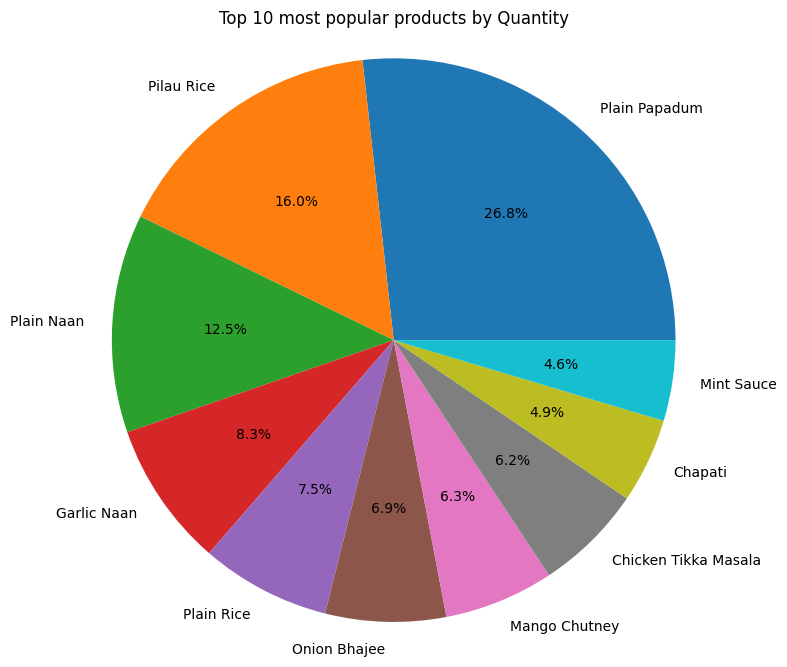

In [62]:
import matplotlib.pyplot as plt


df = pd.read_csv("restaurant_data.csv")
product_numbers = df.groupby(["product_id", "name"])["quantity"].sum().reset_index()
top_products = product_numbers.sort_values(by="quantity", ascending=False).head(10)

plt.figure(figsize=(8, 8))
plt.pie(top_products["quantity"], labels=top_products["name"], autopct="%1.1f%%")
plt.title("Top 10 most popular products by Quantity")
plt.axis("equal")
plt.show()



# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

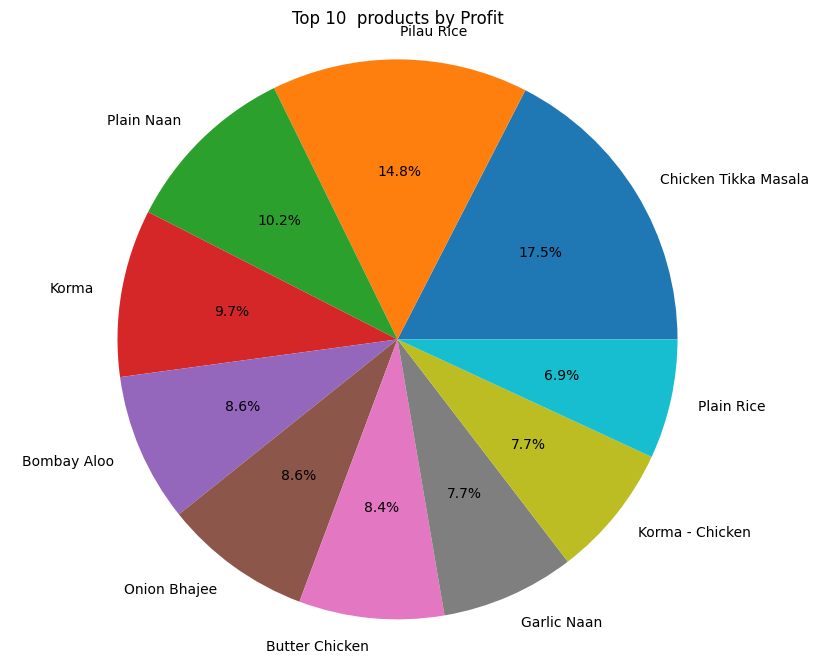

In [63]:
df["item_price"] = df["quantity"] * df["price"]
product_profits = df.groupby(["product_id", "name"])["item_price"].sum().reset_index()
top_profit_products = product_profits.sort_values(by="item_price", ascending=False).head(10)

plt.figure(figsize=(10, 8))
plt.pie(top_profit_products["item_price"], labels=top_profit_products["name"], autopct="%1.1f%%")
plt.title("Top 10  products by Profit")
plt.axis("equal")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

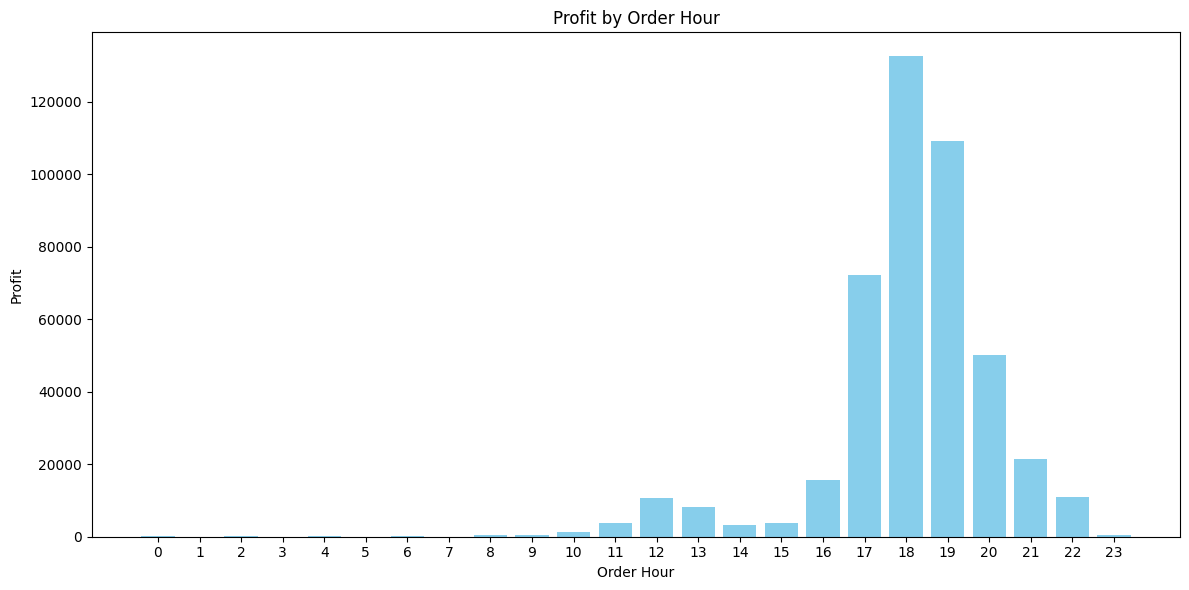

In [64]:
df["datetime"] = pd.to_datetime(df["datetime"])
df["order_hour"] = df["datetime"].dt.hour

hourly_profit = df.groupby("order_hour")["item_price"].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(hourly_profit["order_hour"], hourly_profit["item_price"], color="skyblue")
plt.title("Profit by Order Hour")
plt.xlabel("Order Hour")
plt.ylabel("Profit")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

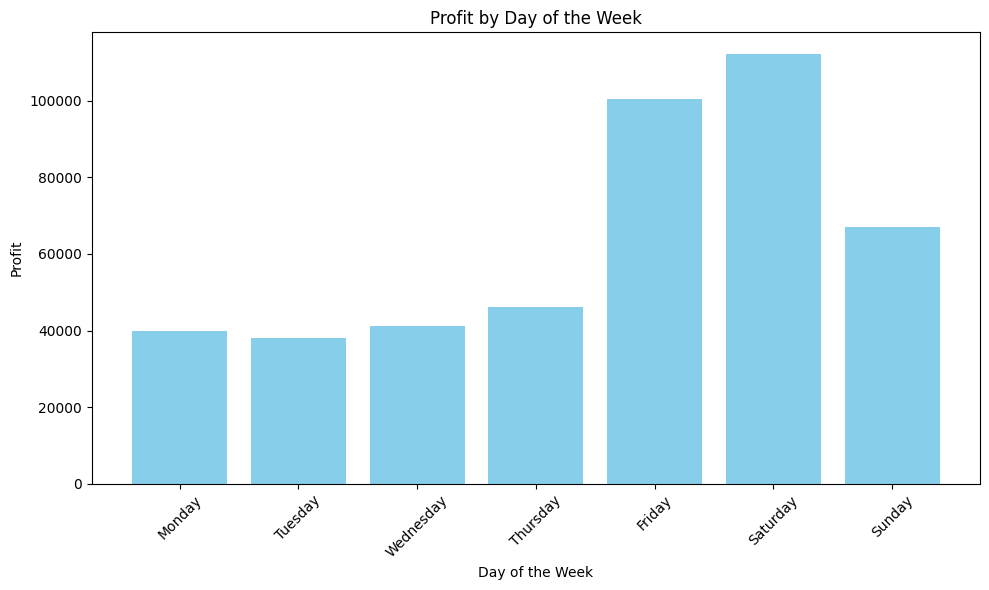

In [65]:
df["order_day"] = df["datetime"].dt.dayofweek
day_mapping = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
               4: "Friday", 5: "Saturday", 6: "Sunday"}
df["order_day_name"] = df["order_day"].map(day_mapping)

daily_profit = df.groupby("order_day_name")["item_price"].sum().reindex(day_mapping.values())

plt.figure(figsize=(10, 6))
plt.bar(daily_profit.index, daily_profit, color="skyblue")
plt.title("Profit by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()